# Overall Classification

3 different classification tasks:
* Ecoli
* Coliform
* Ecoli + Coliform

Classes are defined through thresholds

# BEAR IN MIND

* **Precision**: How many of our predictions are correct? Precision is the ability of a classifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

* **Recall**: How well do you notice the phenomenon? Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

* **F1 score**: The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

* **Support**: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = os.path.join("..", "..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

full_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

# Load Data

In [3]:
full_df = pd.read_excel(full_dataset_path)

In [4]:
full_df.columns.to_list()

['DateTime',
 'Site',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Temp C_std',
 'Ph_mean',
 'Ph_std',
 'Cond (ms)_mean',
 'Cond (ms)_std',
 'Coliform (1ml)_mean',
 'Coliform (1ml)_std',
 'Ecoli (1ml)_mean',
 'Ecoli (1ml)_std',
 'cso_hinterland',
 'cso_middle',
 'cso_sea',
 'rained',
 'mean_rainfall',
 'tide_value',
 'bacteria_sum']

In [5]:
# full_df = full_df[full_df["DateTime"] > "2023-05-01"]

In [6]:
# start with site A
full_df = full_df[full_df["Site"] == "B"]

In [7]:
full_df = full_df.drop(
    columns=[
        "Site",
        "Technician Water Quality",
        "Technician Counting",
        "Temp C_std",
        "Ph_std",
        "Cond (ms)_std",
        "Coliform (1ml)_std",
        "Ecoli (1ml)_std",
    ]
)

# Bacteria Sum

In [8]:
bacteria_df = full_df.drop(columns=["Ecoli (1ml)_mean", "Coliform (1ml)_mean"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

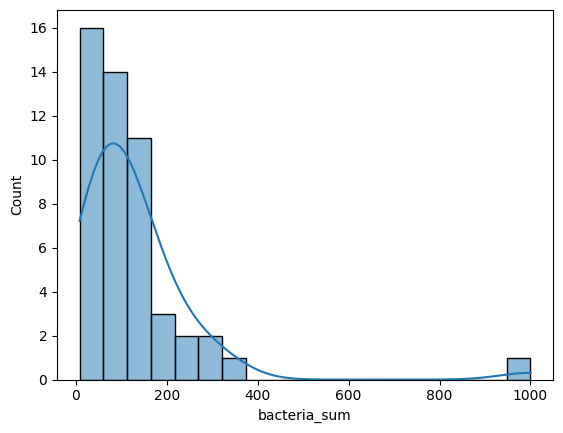

In [9]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

In [10]:
# scale to log scale
bacteria_df["bacteria_sum"] = np.log10(bacteria_df["bacteria_sum"])

<Axes: xlabel='bacteria_sum', ylabel='Count'>

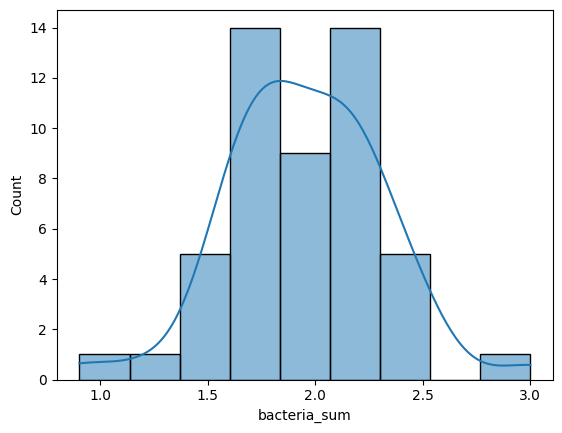

In [11]:
sns.histplot(bacteria_df["bacteria_sum"], kde=True)

## Define classes

In [12]:
# define function to classify ecoli levels based on quartiles
def ecoli_level(value):
    if value <= bacteria_df["bacteria_sum"].quantile(0.5):
        return "Low"
    else:
        return "High"

In [13]:
# define classes for Ecoli based on quantiles
bacteria_df["Class"] = bacteria_df["bacteria_sum"].apply(ecoli_level)

bacteria_df.drop(columns=["bacteria_sum"], inplace=True)

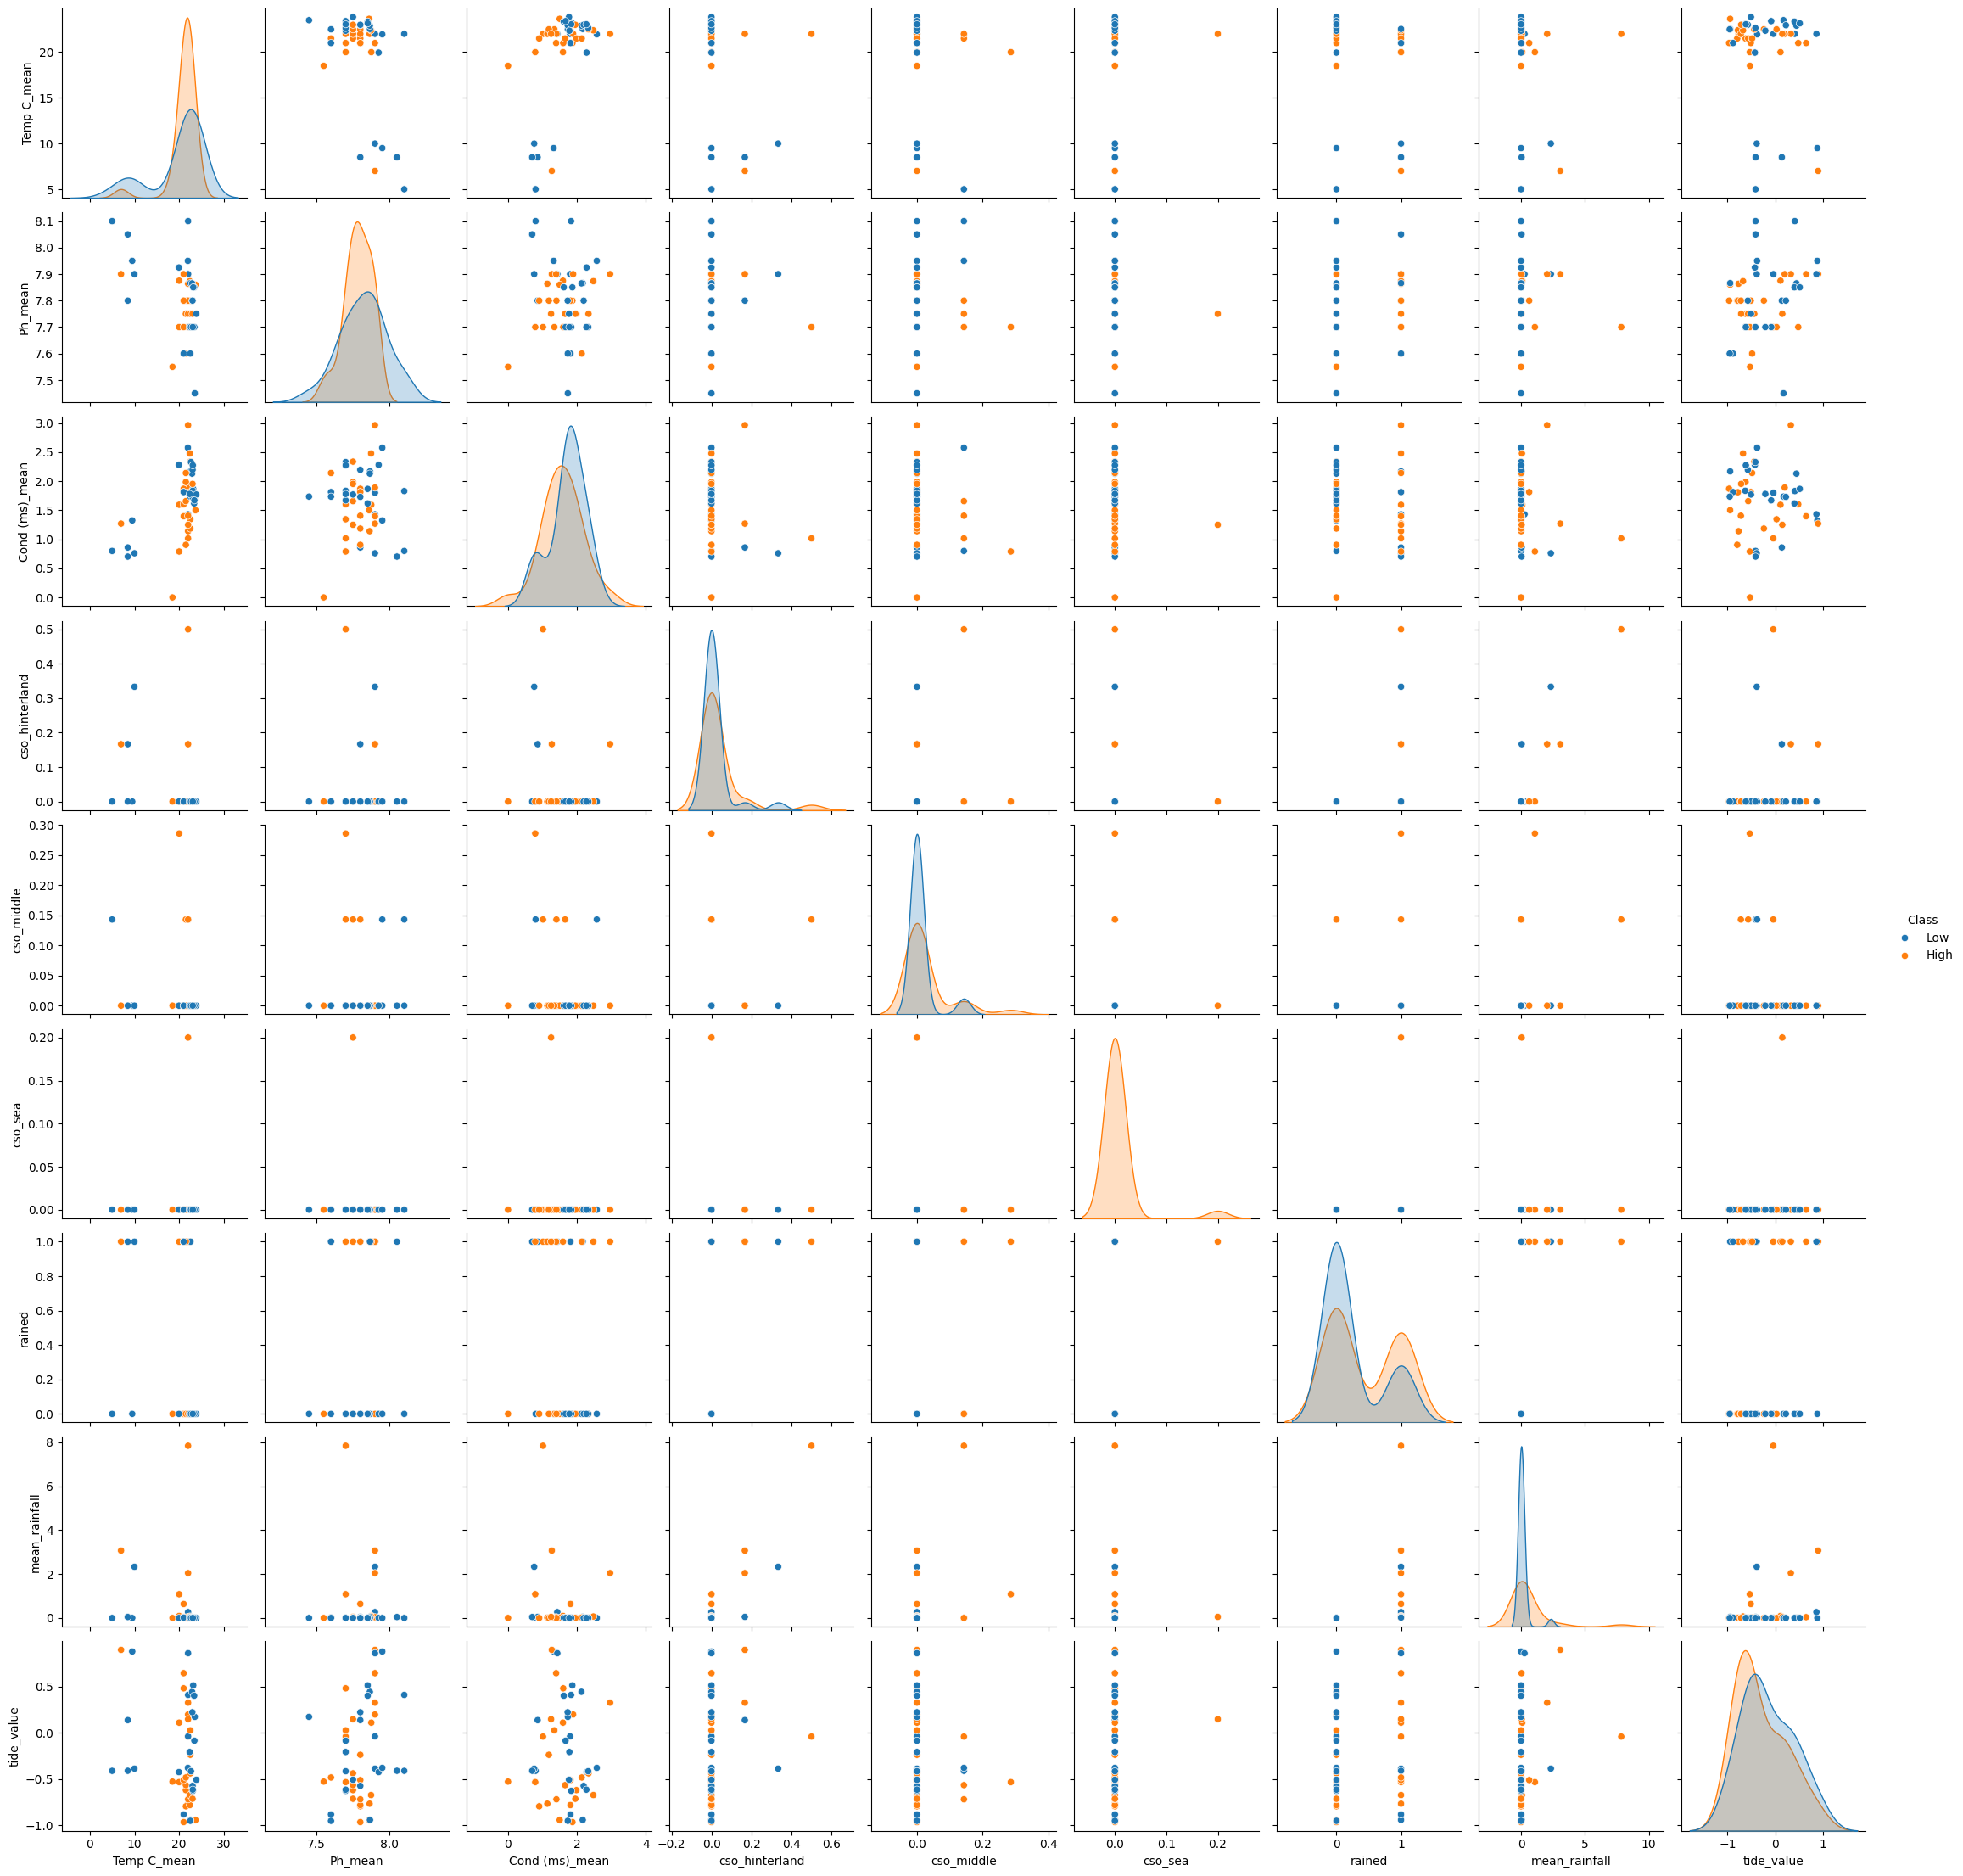

In [14]:
sns.pairplot(bacteria_df, hue="Class")

In [15]:
# count number of samples in each class
bacteria_df["Class"].value_counts()

Class
Low     25
High    25
Name: count, dtype: int64

# Perform Classification

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [17]:
bacteria_df.isna().sum()

DateTime          0
Temp C_mean       0
Ph_mean           0
Cond (ms)_mean    0
cso_hinterland    0
cso_middle        0
cso_sea           0
rained            0
mean_rainfall     0
tide_value        0
Class             0
dtype: int64

In [18]:
X = bacteria_df.drop(
    columns=[
        "DateTime",
        "Class",
    ]
).copy()
y = bacteria_df["Class"].copy()

y = y.map({"Low": 0, "High": 1})

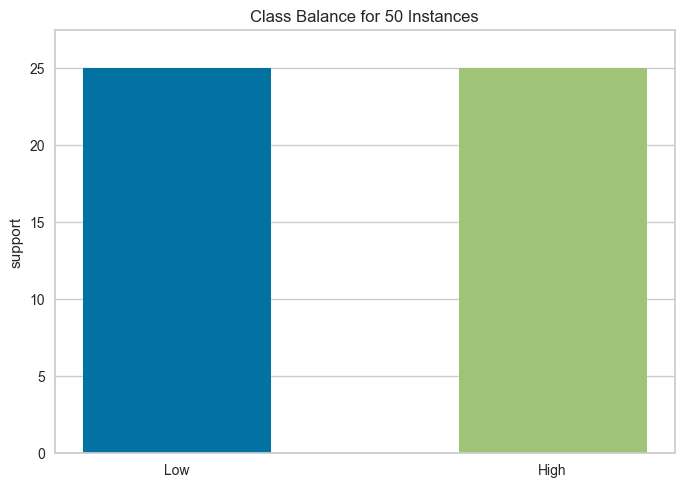

<Axes: title={'center': 'Class Balance for 50 Instances'}, ylabel='support'>

In [19]:
from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    ConfusionMatrix,
    PrecisionRecallCurve,
    ClassBalance,
)


classes = bacteria_df["Class"].unique()

visualizer = ClassBalance(labels=classes)
visualizer.fit(y)
visualizer.show()

# Feature Selection

In [20]:
import warnings
from sklearn import model_selection
from sklearn.feature_selection import SequentialFeatureSelector

selected_features = []

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    LinearSVC(),
    SGDClassifier(),
    xgb.XGBClassifier(),
]

warnings.filterwarnings("ignore")

for model in models:
    print("=" * 80)
    print(model)
    print("=" * 80)
    print()

    cv = model_selection.LeaveOneOut()

    for direction in ["forward", "backward"]:
        print("Direction:", direction)
        print()
        sfs = SequentialFeatureSelector(
            model, n_features_to_select="auto", direction=direction, cv=cv
        )
        sfs.fit(X, y)
        print(X.columns[sfs.get_support()])
        print("-" * 10)

        selected_features.append(X.columns[sfs.get_support()].to_list())


# get the most common features
from collections import Counter

selected_features = Counter(
    [feature for sublist in selected_features for feature in sublist]
)

LogisticRegression()

Direction: forward

Index(['cso_hinterland', 'cso_middle', 'cso_sea', 'rained'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Cond (ms)_mean', 'rained', 'mean_rainfall',
       'tide_value'],
      dtype='object')
----------
RandomForestClassifier()

Direction: forward

Index(['Temp C_mean', 'Ph_mean', 'cso_sea', 'tide_value'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Ph_mean', 'Cond (ms)_mean', 'cso_hinterland',
       'tide_value'],
      dtype='object')
----------
DecisionTreeClassifier()

Direction: forward

Index(['Temp C_mean', 'Ph_mean', 'cso_sea', 'tide_value'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Cond (ms)_mean', 'cso_middle', 'cso_sea', 'tide_value'], dtype='object')
----------
KNeighborsClassifier()

Direction: forward

Index(['Temp C_mean', 'Cond (ms)_mean', 'cso_hinterland', 'cso_sea'], dtype='object')
----------
Direction: backward

Index(['Temp C_mean', 'Ph_me

KeyboardInterrupt: 

In [ ]:
selected_features

Counter({'Temp C_mean': 14,
         'Cond (ms)_mean': 11,
         'rained': 10,
         'Ph_mean': 10,
         'cso_sea': 9,
         'tide_value': 9,
         'cso_hinterland': 8,
         'cso_middle': 5,
         'mean_rainfall': 5})

In [ ]:
%%script false --no-raise-error
# Comment this line to keep all features

# Drop the features that are not selected at least half of the times

X.drop(
    columns=[
        "Cond (ms)_mean",
        "Ph_mean",
        "cso_hinterland",
        "cso_middle",
    ],
    inplace=True,
)

# Model Selection

In [20]:
import optuna

In [21]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier",
        [
            "RandomForest",
            "XGBoost",
            "LogisticRegression",
            "SVC",
            "KNN",
            "DecisionTree",
            "GaussianNB",
            "LinearSVC",
            "SGDClassifier",
        ],
    )

    if classifier_name == "RandomForest":
        model = RandomForestClassifier(
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        model = xgb.XGBClassifier(
            random_state=42,
        )

    elif classifier_name == "LogisticRegression":
        model = LogisticRegression(
            random_state=42,
        )

    elif classifier_name == "SVC":
        model = SVC(
            random_state=42,
        )

    elif classifier_name == "KNN":
        model = KNeighborsClassifier()

    elif classifier_name == "DecisionTree":
        model = DecisionTreeClassifier(
            random_state=42,
        )

    elif classifier_name == "GaussianNB":
        model = GaussianNB()

    elif classifier_name == "LinearSVC":
        model = LinearSVC(
            random_state=42,
        )

    elif classifier_name == "SGDClassifier":
        model = SGDClassifier(
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.LeaveOneOut()
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [145]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Model Selection - Bacteria - Site B - All Data",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-06 13:07:34,956] Using an existing study with name 'Model Selection - Bacteria - Site B - All Data' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-06 13:07:37,483] Trial 100 finished with value: 0.7 and parameters: {'classifier': 'RandomForest'}. Best is trial 15 with value: 0.74.
[I 2024-03-06 13:07:37,577] Trial 101 finished with value: 0.74 and parameters: {'classifier': 'DecisionTree'}. Best is trial 15 with value: 0.74.
[I 2024-03-06 13:07:37,667] Trial 102 finished with value: 0.74 and parameters: {'classifier': 'DecisionTree'}. Best is trial 15 with value: 0.74.
[I 2024-03-06 13:07:37,763] Trial 103 finished with value: 0.74 and parameters: {'classifier': 'DecisionTree'}. Best is trial 15 with value: 0.74.
[I 2024-03-06 13:07:37,854] Trial 104 finished with value: 0.74 and parameters: {'classifier': 'DecisionTree'}. Best is trial 15 with value: 0.74.
[I 2024-03-06 13:07:37,950] Trial 105 finished with value: 0.74 and parameters: {'classifier': 'DecisionTree'}. Best is trial 15 with value: 0.74.
[I 2024-03-06 13:07:49,106] Trial 106 finished with value: 0.66 and parameters: {'classifier': 'XGBoost'}. Best is tria

Since the Condunctivity should be proportional with the tide_value, remove the cond.

Leave just mean_rainfall, tide_value, Temp, rained and cso_sea

In [146]:
study.best_params

{'classifier': 'DecisionTree'}

# Hyperparameter Tuning

In [25]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "XGBoost"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        max_features = trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        )
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            criterion=criterion,
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        learning_rate = trial.suggest_float(
            "learning_rate", 0.01, 0.1, log=True
        )
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.LeaveOneOut()
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [26]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///bacteria.sqlite3",
    study_name="Hyperparameter Tuning - Bacteria - Site B - All Data",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-06 14:09:04,558] Using an existing study with name 'Hyperparameter Tuning - Bacteria - Site B - All Data' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:08,856] Trial 107 finished with value: 0.72 and parameters: {'n_estimators': 260, 'max_depth': 30.7125229580358, 'learning_rate': 0.011608726733306502, 'subsample': 0.48889397769963644, 'colsample_bytree': 0.9634121703457709}. Best is trial 10 with value: 0.7433333333333333.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:13,124] Trial 108 finished with value: 0.74 and parameters: {'n_estimators': 410, 'max_depth': 46.16792551054701, 'learning_rate': 0.02423054602980961, 'subsample': 0.5879779175742436, 'colsample_bytree': 0.11472536874160144}. Best is trial 10 with value: 0.7433333333333333.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:15,135] Trial 109 finished with value: 0.7 and parameters: {'n_estimators': 100, 'max_depth': 34.9905229202418, 'learning_rate': 0.09719593201122387, 'subsample': 0.9972880131968693, 'colsample_bytree': 0.9810238745779115}. Best is trial 10 with value: 0.7433333333333333.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:16,783] Trial 110 finished with value: 0.68 and parameters: {'n_estimators': 100, 'max_depth': 28.607855039567244, 'learning_rate': 0.04005359637567247, 'subsample': 0.39291406394462636, 'colsample_bytree': 0.3807443310330907}. Best is trial 10 with value: 0.7433333333333333.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:20,174] Trial 111 finished with value: 0.78 and parameters: {'n_estimators': 220, 'max_depth': 19.591928449682943, 'learning_rate': 0.017748823597828395, 'subsample': 0.6620922438344214, 'colsample_bytree': 0.8167412457734489}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:23,577] Trial 112 finished with value: 0.74 and parameters: {'n_estimators': 200, 'max_depth': 21.685787095547795, 'learning_rate': 0.017297879079812544, 'subsample': 0.6797898521758441, 'colsample_bytree': 0.7896948271285441}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:27,739] Trial 113 finished with value: 0.7 and parameters: {'n_estimators': 250, 'max_depth': 17.704536827938558, 'learning_rate': 0.01786319524810059, 'subsample': 0.7467272689125377, 'colsample_bytree': 0.8254825444569098}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:31,328] Trial 114 finished with value: 0.64 and parameters: {'n_estimators': 310, 'max_depth': 65.59734403436123, 'learning_rate': 0.060743065213070886, 'subsample': 0.3907497893140001, 'colsample_bytree': 0.43074563775886765}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:34,615] Trial 115 finished with value: 0.72 and parameters: {'n_estimators': 180, 'max_depth': 12.785438711763696, 'learning_rate': 0.015086564321732837, 'subsample': 0.5970634068539251, 'colsample_bytree': 0.828593871289149}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:42,682] Trial 116 finished with value: 0.66 and parameters: {'n_estimators': 410, 'max_depth': 19.736595302486396, 'learning_rate': 0.03088464573147296, 'subsample': 0.8195648009598677, 'colsample_bytree': 0.5324921784515381}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:45,188] Trial 117 finished with value: 0.68 and parameters: {'n_estimators': 200, 'max_depth': 40.15080176585759, 'learning_rate': 0.021726856790703776, 'subsample': 0.4368639079608426, 'colsample_bytree': 0.202143317147836}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:49,302] Trial 118 finished with value: 0.5 and parameters: {'n_estimators': 650, 'max_depth': 57.73629989780536, 'learning_rate': 0.01330096369582531, 'subsample': 0.10882555907912989, 'colsample_bytree': 0.8948529433802545}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:51,205] Trial 119 finished with value: 0.64 and parameters: {'n_estimators': 150, 'max_depth': 33.713295573440256, 'learning_rate': 0.03381428154603006, 'subsample': 0.2986444804956409, 'colsample_bytree': 0.6990577546862643}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:53,231] Trial 120 finished with value: 0.7 and parameters: {'n_estimators': 110, 'max_depth': 42.22680122356883, 'learning_rate': 0.05877202097697903, 'subsample': 0.6725202994433794, 'colsample_bytree': 0.5307701215256672}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:09:59,107] Trial 121 finished with value: 0.68 and parameters: {'n_estimators': 300, 'max_depth': 33.79781634263484, 'learning_rate': 0.02036805856459478, 'subsample': 0.9486822350017425, 'colsample_bytree': 0.7580651432364295}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:03,200] Trial 122 finished with value: 0.72 and parameters: {'n_estimators': 240, 'max_depth': 28.20482184336885, 'learning_rate': 0.028963836278780724, 'subsample': 0.8357194589003101, 'colsample_bytree': 0.44048295356134193}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:06,334] Trial 123 finished with value: 0.66 and parameters: {'n_estimators': 160, 'max_depth': 71.47455528573362, 'learning_rate': 0.04024281793988487, 'subsample': 0.5174011957239188, 'colsample_bytree': 0.9122364924869152}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:10,902] Trial 124 finished with value: 0.74 and parameters: {'n_estimators': 230, 'max_depth': 15.356977133490922, 'learning_rate': 0.014084497338562476, 'subsample': 0.6724289882170458, 'colsample_bytree': 0.619109238018866}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:12,932] Trial 125 finished with value: 0.62 and parameters: {'n_estimators': 160, 'max_depth': 56.833950484460644, 'learning_rate': 0.07274329776756891, 'subsample': 0.2554788727570802, 'colsample_bytree': 0.2712757771501651}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:23,147] Trial 126 finished with value: 0.68 and parameters: {'n_estimators': 500, 'max_depth': 24.255480868562344, 'learning_rate': 0.010855875290004886, 'subsample': 0.8676827128290541, 'colsample_bytree': 0.7414194518380637}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:28,540] Trial 127 finished with value: 0.66 and parameters: {'n_estimators': 330, 'max_depth': 46.591507066965875, 'learning_rate': 0.038544934170181046, 'subsample': 0.750895085983308, 'colsample_bytree': 0.9009545904097838}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:33,240] Trial 128 finished with value: 0.7 and parameters: {'n_estimators': 420, 'max_depth': 36.75463231103666, 'learning_rate': 0.018017279692192516, 'subsample': 0.5776810156271542, 'colsample_bytree': 0.5139700004375009}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:34,981] Trial 129 finished with value: 0.68 and parameters: {'n_estimators': 100, 'max_depth': 53.2438777318823, 'learning_rate': 0.0258995162753302, 'subsample': 0.4629805029950784, 'colsample_bytree': 0.856027319888675}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:36,630] Trial 130 finished with value: 0.6 and parameters: {'n_estimators': 130, 'max_depth': 40.70733699289996, 'learning_rate': 0.010192252140456973, 'subsample': 0.29174562731075104, 'colsample_bytree': 0.31015185052837935}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:39,464] Trial 131 finished with value: 0.52 and parameters: {'n_estimators': 270, 'max_depth': 29.438903864332183, 'learning_rate': 0.01255454306873588, 'subsample': 0.22460031636412864, 'colsample_bytree': 0.9966998179897588}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:41,795] Trial 132 finished with value: 0.66 and parameters: {'n_estimators': 200, 'max_depth': 46.47763711197623, 'learning_rate': 0.04859200884958365, 'subsample': 0.3354418680647404, 'colsample_bytree': 0.6669986321477351}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:43,592] Trial 133 finished with value: 0.72 and parameters: {'n_estimators': 140, 'max_depth': 38.34030991306122, 'learning_rate': 0.01509170512725773, 'subsample': 0.6472948409304252, 'colsample_bytree': 0.45408393719402795}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:45,329] Trial 134 finished with value: 0.58 and parameters: {'n_estimators': 220, 'max_depth': 80.30520620344437, 'learning_rate': 0.07312014903131554, 'subsample': 0.18621117438095747, 'colsample_bytree': 0.7211857066540244}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:47,700] Trial 135 finished with value: 0.72 and parameters: {'n_estimators': 150, 'max_depth': 26.58433423101799, 'learning_rate': 0.021315244855150663, 'subsample': 0.7556736637312069, 'colsample_bytree': 0.6017152062808865}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:53,563] Trial 136 finished with value: 0.7 and parameters: {'n_estimators': 740, 'max_depth': 22.58976862830253, 'learning_rate': 0.04791177262107429, 'subsample': 0.5249768360596396, 'colsample_bytree': 0.10282104639400819}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:55,836] Trial 137 finished with value: 0.74 and parameters: {'n_estimators': 180, 'max_depth': 51.63834214398416, 'learning_rate': 0.027186980079754855, 'subsample': 0.9037852729160538, 'colsample_bytree': 0.18148100811739293}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:10:59,078] Trial 138 finished with value: 0.66 and parameters: {'n_estimators': 280, 'max_depth': 98.05846096158267, 'learning_rate': 0.03353031751085792, 'subsample': 0.39059079301212385, 'colsample_bytree': 0.9397658075035367}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:03,281] Trial 139 finished with value: 0.7 and parameters: {'n_estimators': 410, 'max_depth': 45.417045327902194, 'learning_rate': 0.023502207295134636, 'subsample': 0.5912645641620873, 'colsample_bytree': 0.35219781685551343}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:04,476] Trial 140 finished with value: 0.6 and parameters: {'n_estimators': 100, 'max_depth': 32.986108308593984, 'learning_rate': 0.01648813174480346, 'subsample': 0.716506981453444, 'colsample_bytree': 0.11430926586742159}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:06,193] Trial 141 finished with value: 0.72 and parameters: {'n_estimators': 140, 'max_depth': 43.63145480032358, 'learning_rate': 0.019670135502816457, 'subsample': 0.6125963418543653, 'colsample_bytree': 0.2659818191464905}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:09,832] Trial 142 finished with value: 0.68 and parameters: {'n_estimators': 360, 'max_depth': 36.57071462024772, 'learning_rate': 0.02383013117589844, 'subsample': 0.5615660677327595, 'colsample_bytree': 0.7852675349769099}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:16,300] Trial 143 finished with value: 0.72 and parameters: {'n_estimators': 550, 'max_depth': 49.74069721806471, 'learning_rate': 0.012001866261135795, 'subsample': 0.9857806636169717, 'colsample_bytree': 0.48031165925892644}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:21,054] Trial 144 finished with value: 0.66 and parameters: {'n_estimators': 470, 'max_depth': 57.598805982094795, 'learning_rate': 0.03760960479371854, 'subsample': 0.792963866306541, 'colsample_bytree': 0.575184286925438}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:22,449] Trial 145 finished with value: 0.64 and parameters: {'n_estimators': 190, 'max_depth': 30.663425636200486, 'learning_rate': 0.015531304407070774, 'subsample': 0.4281212208452143, 'colsample_bytree': 0.18752669090671825}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:30,639] Trial 146 finished with value: 0.68 and parameters: {'n_estimators': 990, 'max_depth': 65.26904334126888, 'learning_rate': 0.018547930307819153, 'subsample': 0.4900121991833162, 'colsample_bytree': 0.6451381966292618}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:32,273] Trial 147 finished with value: 0.72 and parameters: {'n_estimators': 130, 'max_depth': 17.619095974285493, 'learning_rate': 0.05630816962781102, 'subsample': 0.6293685521961728, 'colsample_bytree': 0.3702420508326544}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:35,256] Trial 148 finished with value: 0.68 and parameters: {'n_estimators': 230, 'max_depth': 39.152758287125266, 'learning_rate': 0.029918062860829042, 'subsample': 0.7125103303616657, 'colsample_bytree': 0.8476255095162833}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:37,547] Trial 149 finished with value: 0.72 and parameters: {'n_estimators': 180, 'max_depth': 20.479252202802996, 'learning_rate': 0.017155996521566637, 'subsample': 0.6991974340167572, 'colsample_bytree': 0.7982228108699722}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:39,758] Trial 150 finished with value: 0.7 and parameters: {'n_estimators': 210, 'max_depth': 15.023121169940596, 'learning_rate': 0.022586133250630303, 'subsample': 0.5363964900023717, 'colsample_bytree': 0.9433928210325293}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:41,309] Trial 151 finished with value: 0.68 and parameters: {'n_estimators': 120, 'max_depth': 22.043515203232992, 'learning_rate': 0.013334035396283738, 'subsample': 0.7892415781041424, 'colsample_bytree': 0.6866400718520855}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:44,436] Trial 152 finished with value: 0.68 and parameters: {'n_estimators': 260, 'max_depth': 16.99579073345772, 'learning_rate': 0.019480790348970184, 'subsample': 0.663472405286357, 'colsample_bytree': 0.7774673092311607}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:50,174] Trial 153 finished with value: 0.68 and parameters: {'n_estimators': 630, 'max_depth': 26.727310601063095, 'learning_rate': 0.043307930007049876, 'subsample': 0.8910584743411213, 'colsample_bytree': 0.5616369217723002}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:52,635] Trial 154 finished with value: 0.66 and parameters: {'n_estimators': 310, 'max_depth': 11.499744902508215, 'learning_rate': 0.027106352801815826, 'subsample': 0.35871197749847533, 'colsample_bytree': 0.8669711166829165}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:57,054] Trial 155 finished with value: 0.72 and parameters: {'n_estimators': 370, 'max_depth': 19.91287129929072, 'learning_rate': 0.014088340582108708, 'subsample': 0.8377118505123307, 'colsample_bytree': 0.3992979064779021}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:11:58,756] Trial 156 finished with value: 0.7 and parameters: {'n_estimators': 170, 'max_depth': 42.50639511015665, 'learning_rate': 0.033007069930494896, 'subsample': 0.46980173758270805, 'colsample_bytree': 0.6388674886210246}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:00,649] Trial 157 finished with value: 0.7 and parameters: {'n_estimators': 100, 'max_depth': 31.86198131900531, 'learning_rate': 0.016150478389623867, 'subsample': 0.9422641480197551, 'colsample_bytree': 0.5027714802193166}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:03,233] Trial 158 finished with value: 0.74 and parameters: {'n_estimators': 210, 'max_depth': 36.172080739724336, 'learning_rate': 0.011058431518962554, 'subsample': 0.5612491448543471, 'colsample_bytree': 0.818146389804381}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:06,572] Trial 159 finished with value: 0.76 and parameters: {'n_estimators': 240, 'max_depth': 14.47751712117712, 'learning_rate': 0.013643178184567553, 'subsample': 0.6825590098790209, 'colsample_bytree': 0.7325779467529829}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:09,875] Trial 160 finished with value: 0.7 and parameters: {'n_estimators': 250, 'max_depth': 18.72591083911826, 'learning_rate': 0.02090468932967189, 'subsample': 0.6285847414010505, 'colsample_bytree': 0.7151146041322897}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:12,071] Trial 161 finished with value: 0.7 and parameters: {'n_estimators': 130, 'max_depth': 12.662914451935777, 'learning_rate': 0.013759942860194527, 'subsample': 0.7353215418780432, 'colsample_bytree': 0.7463598848905965}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:14,769] Trial 162 finished with value: 0.72 and parameters: {'n_estimators': 160, 'max_depth': 13.543268306662325, 'learning_rate': 0.012466842972257532, 'subsample': 0.6916889110002986, 'colsample_bytree': 0.8677624716387926}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:19,203] Trial 163 finished with value: 0.66 and parameters: {'n_estimators': 290, 'max_depth': 47.93425546943295, 'learning_rate': 0.01728068309413531, 'subsample': 0.7792718582466843, 'colsample_bytree': 0.9178037203512897}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:21,540] Trial 164 finished with value: 0.76 and parameters: {'n_estimators': 190, 'max_depth': 15.633869337606503, 'learning_rate': 0.010006580701712026, 'subsample': 0.6474865528838597, 'colsample_bytree': 0.6851808314531298}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:23,380] Trial 165 finished with value: 0.68 and parameters: {'n_estimators': 120, 'max_depth': 16.183966978431677, 'learning_rate': 0.01047093821901725, 'subsample': 0.5949138043940361, 'colsample_bytree': 0.6058913712306767}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:25,116] Trial 166 finished with value: 0.7 and parameters: {'n_estimators': 160, 'max_depth': 11.948962122745773, 'learning_rate': 0.011321564768755508, 'subsample': 0.5025129097553089, 'colsample_bytree': 0.679135249669457}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:34,143] Trial 167 finished with value: 0.72 and parameters: {'n_estimators': 860, 'max_depth': 14.207777354982753, 'learning_rate': 0.014882483323899335, 'subsample': 0.6476224842110476, 'colsample_bytree': 0.5428531002280625}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:38,818] Trial 168 finished with value: 0.7 and parameters: {'n_estimators': 330, 'max_depth': 44.530208481506655, 'learning_rate': 0.01282209985106237, 'subsample': 0.8281216288904812, 'colsample_bytree': 0.713530126169433}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:41,479] Trial 169 finished with value: 0.64 and parameters: {'n_estimators': 190, 'max_depth': 16.052366160238194, 'learning_rate': 0.09815859529978345, 'subsample': 0.6874361291660629, 'colsample_bytree': 0.7586755728484276}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:44,433] Trial 170 finished with value: 0.7 and parameters: {'n_estimators': 230, 'max_depth': 54.289456098465415, 'learning_rate': 0.010142958062942853, 'subsample': 0.7319867228950155, 'colsample_bytree': 0.8174509907983054}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:46,226] Trial 171 finished with value: 0.74 and parameters: {'n_estimators': 140, 'max_depth': 23.26509955679866, 'learning_rate': 0.011849160826509537, 'subsample': 0.6198622622565518, 'colsample_bytree': 0.8848256347046269}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:50,520] Trial 172 finished with value: 0.66 and parameters: {'n_estimators': 460, 'max_depth': 21.408354514405268, 'learning_rate': 0.024666931653373983, 'subsample': 0.5491501353856193, 'colsample_bytree': 0.6262111391004191}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:51,854] Trial 173 finished with value: 0.68 and parameters: {'n_estimators': 100, 'max_depth': 18.73309844644802, 'learning_rate': 0.01851910839948353, 'subsample': 0.7700591794718412, 'colsample_bytree': 0.7327622219865454}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:56,421] Trial 174 finished with value: 0.74 and parameters: {'n_estimators': 560, 'max_depth': 41.23576052376434, 'learning_rate': 0.014401309316079039, 'subsample': 0.6614779311024888, 'colsample_bytree': 0.1421638425362578}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:12:58,554] Trial 175 finished with value: 0.7 and parameters: {'n_estimators': 210, 'max_depth': 37.75936978368974, 'learning_rate': 0.022031817978877377, 'subsample': 0.5784370846969039, 'colsample_bytree': 0.23403608293446432}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:01,212] Trial 176 finished with value: 0.74 and parameters: {'n_estimators': 270, 'max_depth': 34.17684613294922, 'learning_rate': 0.016007370149863743, 'subsample': 0.5178027148711005, 'colsample_bytree': 0.8344697611573808}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:03,525] Trial 177 finished with value: 0.68 and parameters: {'n_estimators': 170, 'max_depth': 25.353224890240597, 'learning_rate': 0.019399377210720537, 'subsample': 0.8062152624195582, 'colsample_bytree': 0.6582200267477372}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:10,422] Trial 178 finished with value: 0.68 and parameters: {'n_estimators': 690, 'max_depth': 10.119353229078556, 'learning_rate': 0.026571331061111297, 'subsample': 0.8609598648196972, 'colsample_bytree': 0.7693844572791425}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:13,103] Trial 179 finished with value: 0.76 and parameters: {'n_estimators': 230, 'max_depth': 14.813491834213469, 'learning_rate': 0.013285307885479889, 'subsample': 0.677620686741758, 'colsample_bytree': 0.7992983566307925}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:15,996] Trial 180 finished with value: 0.74 and parameters: {'n_estimators': 240, 'max_depth': 14.547651437531567, 'learning_rate': 0.01170075980319385, 'subsample': 0.6463092425045996, 'colsample_bytree': 0.8009798486173717}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:18,284] Trial 181 finished with value: 0.72 and parameters: {'n_estimators': 120, 'max_depth': 13.260797092296352, 'learning_rate': 0.010938904432669585, 'subsample': 0.7547644373842378, 'colsample_bytree': 0.9544102193403396}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:21,126] Trial 182 finished with value: 0.72 and parameters: {'n_estimators': 190, 'max_depth': 15.872214005046668, 'learning_rate': 0.015081990249681166, 'subsample': 0.7168585188141176, 'colsample_bytree': 0.694798075870064}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:23,680] Trial 183 finished with value: 0.72 and parameters: {'n_estimators': 150, 'max_depth': 16.749218380433074, 'learning_rate': 0.012898523376641028, 'subsample': 0.6022027808480184, 'colsample_bytree': 0.9780649702082677}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:26,291] Trial 184 finished with value: 0.74 and parameters: {'n_estimators': 200, 'max_depth': 49.25080709399947, 'learning_rate': 0.017305390061685397, 'subsample': 0.6822574485603873, 'colsample_bytree': 0.793173315531315}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:27,914] Trial 185 finished with value: 0.7 and parameters: {'n_estimators': 140, 'max_depth': 13.959729920076335, 'learning_rate': 0.013536148527242886, 'subsample': 0.44067120096374324, 'colsample_bytree': 0.9201943394686436}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:31,635] Trial 186 finished with value: 0.74 and parameters: {'n_estimators': 330, 'max_depth': 12.386513070215432, 'learning_rate': 0.020141728463806373, 'subsample': 0.5744396727089986, 'colsample_bytree': 0.882648669049106}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:35,455] Trial 187 finished with value: 0.72 and parameters: {'n_estimators': 250, 'max_depth': 40.04592583590922, 'learning_rate': 0.012124345613635798, 'subsample': 0.6517343255455372, 'colsample_bytree': 0.8393801675805161}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:39,463] Trial 188 finished with value: 0.64 and parameters: {'n_estimators': 380, 'max_depth': 14.920481568888341, 'learning_rate': 0.028696850798738672, 'subsample': 0.5432103938191906, 'colsample_bytree': 0.7541426221400347}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:42,287] Trial 189 finished with value: 0.76 and parameters: {'n_estimators': 220, 'max_depth': 15.235793795819752, 'learning_rate': 0.014608256680436265, 'subsample': 0.6781581289162515, 'colsample_bytree': 0.6196196044734756}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:45,837] Trial 190 finished with value: 0.68 and parameters: {'n_estimators': 280, 'max_depth': 18.08123029613455, 'learning_rate': 0.016378728355886447, 'subsample': 0.7103714502535186, 'colsample_bytree': 0.6720268149561166}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:49,171] Trial 191 finished with value: 0.7 and parameters: {'n_estimators': 230, 'max_depth': 17.050012053871377, 'learning_rate': 0.01472277870272044, 'subsample': 0.6310623284618287, 'colsample_bytree': 0.5901389093362406}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:51,334] Trial 192 finished with value: 0.76 and parameters: {'n_estimators': 180, 'max_depth': 13.272109051371531, 'learning_rate': 0.01797604111863691, 'subsample': 0.6094679509135408, 'colsample_bytree': 0.733913882439281}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:53,076] Trial 193 finished with value: 0.74 and parameters: {'n_estimators': 120, 'max_depth': 11.415919785427716, 'learning_rate': 0.018339417333249848, 'subsample': 0.6069246915612271, 'colsample_bytree': 0.7083945056764649}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:55,575] Trial 194 finished with value: 0.74 and parameters: {'n_estimators': 170, 'max_depth': 13.223999692356935, 'learning_rate': 0.01573702083086736, 'subsample': 0.6825170764584862, 'colsample_bytree': 0.5670191833405446}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:13:58,281] Trial 195 finished with value: 0.7 and parameters: {'n_estimators': 220, 'max_depth': 42.98637694976068, 'learning_rate': 0.023503509886325765, 'subsample': 0.7323985040659152, 'colsample_bytree': 0.7336343403154697}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:00,246] Trial 196 finished with value: 0.72 and parameters: {'n_estimators': 180, 'max_depth': 15.55478050403108, 'learning_rate': 0.010545618118195663, 'subsample': 0.5728516829964896, 'colsample_bytree': 0.6526316144380999}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:03,894] Trial 197 finished with value: 0.72 and parameters: {'n_estimators': 310, 'max_depth': 60.466836380690175, 'learning_rate': 0.01309096565366686, 'subsample': 0.6353321115512084, 'colsample_bytree': 0.31115891490624153}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:06,135] Trial 198 finished with value: 0.74 and parameters: {'n_estimators': 150, 'max_depth': 13.92490369661372, 'learning_rate': 0.013939973201248252, 'subsample': 0.6687268496820234, 'colsample_bytree': 0.6199658999034248}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:07,697] Trial 199 finished with value: 0.72 and parameters: {'n_estimators': 100, 'max_depth': 46.41941615853534, 'learning_rate': 0.01740846671660191, 'subsample': 0.7576127020754101, 'colsample_bytree': 0.8076832753057939}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:10,005] Trial 200 finished with value: 0.66 and parameters: {'n_estimators': 200, 'max_depth': 28.38149874616485, 'learning_rate': 0.08710547527473736, 'subsample': 0.7031343921175232, 'colsample_bytree': 0.7848921112744865}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:13,395] Trial 201 finished with value: 0.7 and parameters: {'n_estimators': 260, 'max_depth': 14.591258353993302, 'learning_rate': 0.02137041546918726, 'subsample': 0.61412147786848, 'colsample_bytree': 0.7632581901569312}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:15,252] Trial 202 finished with value: 0.72 and parameters: {'n_estimators': 120, 'max_depth': 51.53648389883259, 'learning_rate': 0.016916150193831, 'subsample': 0.6685765226518631, 'colsample_bytree': 0.6996830728534026}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:17,783] Trial 203 finished with value: 0.7 and parameters: {'n_estimators': 170, 'max_depth': 19.267707545442608, 'learning_rate': 0.019127918680274438, 'subsample': 0.7351711619994424, 'colsample_bytree': 0.7317104084658784}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:20,463] Trial 204 finished with value: 0.76 and parameters: {'n_estimators': 220, 'max_depth': 35.30325019145695, 'learning_rate': 0.0154423769241137, 'subsample': 0.5954925626571331, 'colsample_bytree': 0.8535255701203162}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:23,495] Trial 205 finished with value: 0.74 and parameters: {'n_estimators': 220, 'max_depth': 32.12356335039528, 'learning_rate': 0.01536143644144931, 'subsample': 0.5836586533138088, 'colsample_bytree': 0.6383722739989175}. Best is trial 111 with value: 0.78.


/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_87359/846075350.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)


[I 2024-03-06 14:14:27,605] Trial 206 finished with value: 0.72 and parameters: {'n_estimators': 290, 'max_depth': 35.636877235435456, 'learning_rate': 0.01239783587622553, 'subsample': 0.49704779796238807, 'colsample_bytree': 0.8575353902682039}. Best is trial 111 with value: 0.78.


In [28]:
study.best_params

{'n_estimators': 220,
 'max_depth': 19.591928449682943,
 'learning_rate': 0.017748823597828395,
 'subsample': 0.6620922438344214,
 'colsample_bytree': 0.8167412457734489}

# Model Evaluation

In [29]:
if study.best_params["classifier"] == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        max_features=study.best_params["max_features"],
        criterion=study.best_params["criterion"],
        random_state=42,
    )

elif study.best_params["classifier"] == "XGBoost":
    model = xgb.XGBClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        learning_rate=study.best_params["learning_rate"],
        subsample=study.best_params["subsample"],
        colsample_bytree=study.best_params["colsample_bytree"],
        random_state=42,
    )

**Warning Note** on inappropriate usage of cross_val_predict

The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalization error.

In [30]:
cv = model_selection.LeaveOneOut()
# perform cross-validation and store the results
y_pred = model_selection.cross_val_predict(
    model, X, y, cv=cv
)

y_pred_proba = model_selection.cross_val_predict(
    model, X, y, cv=cv, method="predict_proba"
)

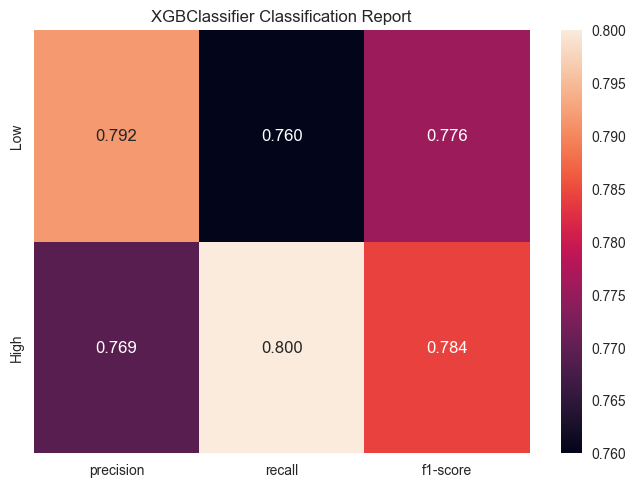

In [31]:
from sklearn.metrics import classification_report


model_name = model.__class__.__name__

report = classification_report(y, y_pred, target_names=classes, output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, fmt=".3f")

plt.title(f"{model_name} Classification Report")
plt.show()

In [32]:
# accuracy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy_score(y, y_pred)

0.78

In [33]:
f1_score(y, y_pred, average="weighted")

0.7799119647859143

In [34]:
precision_score(y, y_pred, average="weighted")

0.780448717948718

In [35]:
recall_score(y, y_pred, average="weighted")

0.78

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(y, y_pred_proba[:, 1])

0.744

<Figure size 1000x1000 with 0 Axes>

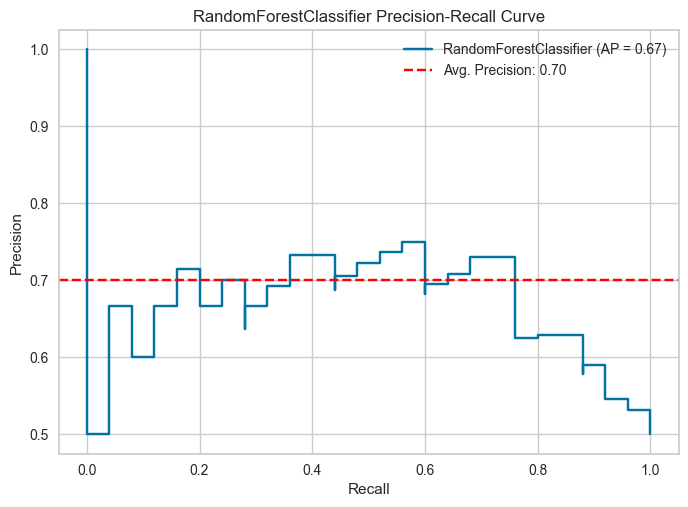

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, precision_score

plt.figure(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y, y_pred_proba[:, 1], name=f"{model.__class__.__name__}")

# plot avg precision
avg_precision = precision_score(y, y_pred, average="weighted")


plt.axhline(avg_precision, color="red", linestyle="--", label=f"Avg. Precision: {avg_precision:.2f}")

plt.setp(plt.gca(), xlabel="Recall", ylabel="Precision")

plt.title(f"{model.__class__.__name__} Precision-Recall Curve")

plt.legend()

plt.show()


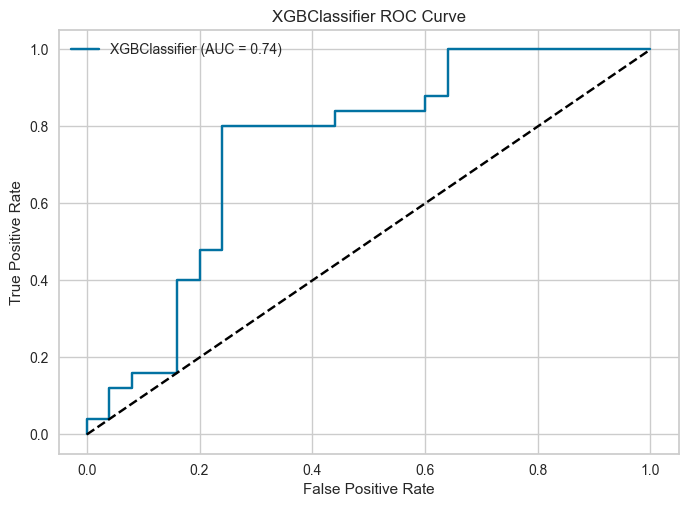

In [37]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y, y_pred_proba[:, 1], pos_label=1, name=f"{model_name}")

sns.lineplot(
    x=[0, 1],
    y=[0, 1],
    color="black",
    linestyle="--",
)

plt.setp(plt.gca(), xlabel="False Positive Rate", ylabel="True Positive Rate")

plt.title(f"{model.__class__.__name__} ROC Curve")

plt.show()

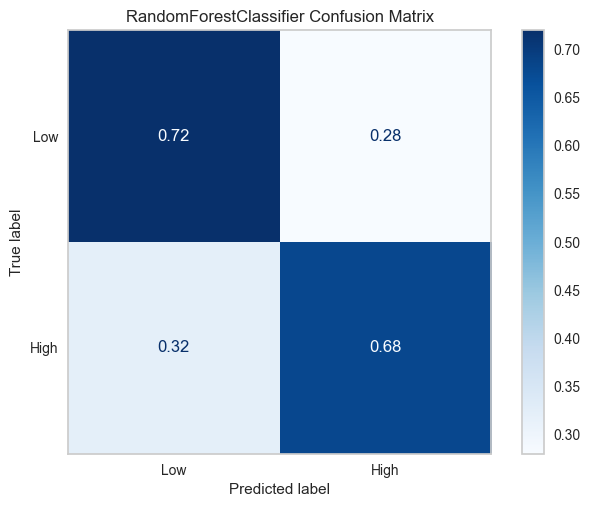

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    display_labels=classes,
    normalize="true",
    cmap="Blues",
)

plt.grid(False)

plt.title(f"{model.__class__.__name__} Confusion Matrix")

plt.show()



# Iteratively Redo Everything with selected model

In [ ]:
%%script false --no-raise-error
model = xgb.XGBClassifier(
    n_estimators=study.best_params["n_estimators"],
    max_depth=int(study.best_params["max_depth"]),
    learning_rate=study.best_params["learning_rate"],
    subsample=study.best_params["subsample"],
    colsample_bytree=study.best_params["colsample_bytree"],
    random_state=42,
)


cv = model_selection.LeaveOneOut()

for direction in ["forward", "backward"]:
    print("Direction:", direction)
    print()
    sfs = SequentialFeatureSelector(
        model, n_features_to_select="auto", direction=direction, cv=cv
    )
    sfs.fit(X, y)
    print(X.columns[sfs.get_support()])
    print("-" * 10)

KeyError: 'learning_rate'

In [ ]:
%%script false --no-raise-error
# Drop the features that are not selected at least half of the times

# Comment this line to keep all features
# %%script false --no-raise-error

X_selected = X.drop(
    columns=[
        "cso_sea",
        "cso_hinterland",
        "cso_middle",
    ]
)

In [ ]:
%%script false --no-raise-error
from sklearn import model_selection


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
    max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
    )

    cv = model_selection.LeaveOneOut()
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [ ]:
%%script false --no-raise-error
study = optuna.create_study(
    direction="maximize",
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-04 17:44:02,988] A new study created in memory with name: no-name-0f24347e-248e-4d84-b62d-d2b5b99f6840


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-04 17:44:08,441] Trial 0 finished with value: 0.6395339745823492 and parameters: {'n_estimators': 860, 'max_depth': 17.937092572013466, 'learning_rate': 0.017379433248035595, 'subsample': 0.12450465263840199, 'colsample_bytree': 0.38137139245066753}. Best is trial 0 with value: 0.6395339745823492.
[I 2024-03-04 17:44:13,340] Trial 1 finished with value: 0.6462843623524739 and parameters: {'n_estimators': 320, 'max_depth': 40.64523471043689, 'learning_rate': 0.011433035601474616, 'subsample': 0.7933215764194306, 'colsample_bytree': 0.5763198683089524}. Best is trial 1 with value: 0.6462843623524739.
[I 2024-03-04 17:44:16,078] Trial 2 finished with value: 0.6567810620751798 and parameters: {'n_estimators': 260, 'max_depth': 20.601779291096996, 'learning_rate': 0.0534655982653228, 'subsample': 0.4416828007001221, 'colsample_bytree': 0.9075530818378332}. Best is trial 2 with value: 0.6567810620751798.
[I 2024-03-04 17:44:19,192] Trial 3 finished with value: 0.6668745809573984 a

KeyboardInterrupt: 